<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/LinearRegression_using_Pysparkmlv1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Perform simple analytics with Pyspark on the real estate valuation dataset and predict the house price per unit area

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the data using pyspark
* derive the insights and visualize the data
* implement linear regression and evaluate using pyspark

### Dataset

The dataset chosen for this mini-project is **Real Estate Valuation dataset**. The data was collected from the historical market of real estate within Sindian District of New Taipei City, the timespan across 2012 August to 2013 July. In the dataset, the response variable (house price per unit area) is calculated in a local unit which is approximately $10000 New Taipei Dollar per 3.3 squared meters. For the collection of regressor data, the transaction dates are transformed into a format such that 2013.250 = 2013 March, 2013.500 = 2013 June etc. The house age was collected in years and the distance to MRT stations is measured in meters.

**Reference:**
The original owner of this Real Estate Valuation dataset is professor I-Cheng Yeh from TamKang University (Department of Civil Engineering). Prof. Yeh donated this dataset to UCI machine learning repository on 18th August 2018. The dataset can be accessed at https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set#[1].

In [ ]:
#@title Install pyspark and Download the data
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/RealEstate.csv
print("Packages installed and dataset downloaded successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Packages installed and dataset downloaded successfully!


In [ ]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

#### Import required packages

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import MinMaxScaler
from handyspark import *

import seaborn as sns
from matplotlib import pyplot as plt

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various spark’s functionality with a lesser number of constructs.

In [ ]:

spark = SparkSession.builder.appName('RealEstate').config('spark.ui.port', '4050').getOrCreate()
spark

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &> /dev/null
!unzip ngrok-stable-linux-amd64.zip &> /dev/null
# get_ipython().system_raw('./ngrok http 4050 &')

In [ ]:
!./ngrok authtoken 2bOIEyUzamnpPbik9XqjNFj7HWy_4maom5pWK1NhtBRZCnxDP

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
get_ipython().system_raw('./ngrok http 4050 &')

In [ ]:
! cat /root/.ngrok2/ngrok.yml

authtoken: 2bOIEyUzamnpPbik9XqjNFj7HWy_4maom5pWK1NhtBRZCnxDP


In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://49de-34-150-217-166.ngrok-free.app


#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [ ]:
csv_path = "/content/RealEstate.csv"
df = spark.read.csv(csv_path, sep = ",", header=True, inferSchema = True)

In [ ]:
df.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double')]

In [ ]:
df.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1 transaction date: double (nullable = true)
 |-- X2 house age: double (nullable = true)
 |-- X3 distance to the nearest MRT station: double (nullable = true)
 |-- X4 number of convenience stores: integer (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- Y house price of unit area: double (nullable = true)



In [ ]:
df.show(5)

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [ ]:
df.count()

414

In [ ]:
# Change column names for easier access
column_names = df.columns
print(column_names)

column_names = column_names[1:-1]
suffix=1

for col in column_names:
    print(col)
    new_col_name = 'X' + str(suffix)
    print(new_col_name)
    suffix+=1
    df = df.withColumnRenamed(col, new_col_name)

df = df.withColumnRenamed('Y house price of unit area', 'Y')

['No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']
X1 transaction date
X1
X2 house age
X2
X3 distance to the nearest MRT station
X3
X4 number of convenience stores
X4
X5 latitude
X5
X6 longitude
X6


In [ ]:
df.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1: double (nullable = true)
 |-- X2: double (nullable = true)
 |-- X3: double (nullable = true)
 |-- X4: integer (nullable = true)
 |-- X5: double (nullable = true)
 |-- X6: double (nullable = true)
 |-- Y: double (nullable = true)



#### Fetch the data using handyspark

* Create a HandyFrame using handyspark `toHandy()` function

* using an instance of `cols` from your HandyFrame, you can retrieve values for given columns in the top N rows

Hint: [toHandy()](https://dvgodoy.github.io/handyspark/includeme.html)

In [ ]:
hdf = df.toHandy()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


### Deriving the insights

#### show the no. of records per month

Hint: Apply [groupby](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.agg.html?highlight=agg#pyspark.sql.GroupedData.agg) on transaction date and count the records using aggregation `agg()`

In [ ]:
hdf.cols['X1'].value_counts(dropna=False)

X1
2012.667    30
2012.750    27
2012.833    31
2012.917    38
2013.000    28
2013.083    46
2013.167    25
2013.250    32
2013.333    29
2013.417    58
2013.500    47
2013.583    23
Name: value_counts, dtype: int64

In [ ]:
df.groupBy("X1").agg(count("*").alias("count")).sort(asc("X1")).show(truncate=False)

+--------+-----+
|X1      |count|
+--------+-----+
|2012.667|30   |
|2012.75 |27   |
|2012.833|31   |
|2012.917|38   |
|2013.0  |28   |
|2013.083|46   |
|2013.167|25   |
|2013.25 |32   |
|2013.333|29   |
|2013.417|58   |
|2013.5  |47   |
|2013.583|23   |
+--------+-----+



#### how much is the increase in the average house price in 2012 to 2013

Hint: Apply [filter](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html) on the transaction date and aggregate the house price using mean

In [ ]:
avg_price_2013 = df.filter(df['X1'] >= 2013).select(avg('Y')).collect()[0][0]
avg_price_2012 = df.filter(df['X1'] < 2013).select(avg('Y')).collect()[0][0]
increase = (avg_price_2013 - avg_price_2012)
(increase)

2.4084325396825506

#### Find the count of houses with no convenience store and show the top 10 records

In [ ]:
df.filter(df['X4'] == 0).show(10)

+---+--------+----+--------+---+--------+---------+----+
| No|      X1|  X2|      X3| X4|      X5|       X6|   Y|
+---+--------+----+--------+---+--------+---------+----+
| 31|  2013.5|25.9| 4519.69|  0|24.94826|121.49587|22.1|
| 36|  2013.5|13.9|4079.418|  0|25.01459|121.51816|27.3|
| 41|  2013.0|13.6|4082.015|  0|24.94155|121.50381|15.9|
| 42|  2013.5|16.8|4066.587|  0|24.94297|121.50342|18.2|
| 49|2013.417|24.2|4605.749|  0|24.94684|121.49578|13.4|
| 56|2012.833|31.7|1160.632|  0|24.94968|121.53009|13.7|
| 65|2013.333|17.5|995.7554|  0|24.96305|121.54915|25.3|
| 74|2013.167|13.8|4082.015|  0|24.94155|121.50381|20.0|
| 88|2013.583|16.9|4066.587|  0|24.94297|121.50342|18.3|
| 89|2012.917| 8.9| 1406.43|  0|24.98573|121.52758|48.0|
+---+--------+----+--------+---+--------+---------+----+
only showing top 10 rows



#### Compare the maximum price of houses *with convenient store* and *without convenience store*

In [ ]:
# filter on X4 and then select max Y
max_price_with_con_store = df.filter(df['X4'] > 0).select(max('Y')).collect()[0][0]
max_price_without_con_store = df.filter(df['X4'] == 0).select(max('Y')).collect()[0][0]
max_price_with_con_store, max_price_without_con_store

(117.5, 55.3)

#### Decode the transaction date

* create a year column separately by removing the decimal places from transaction date column

    Hint: `withColumn()`

* create a month column separately based on the decimal places from the transaction date column

 **Hints:** multiply decimal place number with 12 and apply round off, perform below steps
     
     - use `udf()` from pyspark
     - subtracting `transaction date` from `int(transaction date)` will give the decimal place number
     - multiply the result with 12 and roundoff

To know more about udf(), click [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.udf.html?highlight=udf#pyspark.sql.functions.udf)

In [ ]:
new_df = df.select(df.X1,df.X2,df.X3,df.X4,df.X5,df.X6,df.Y, substring(df.X1, 1, 4))
new_df = new_df.withColumnRenamed('substring(X1, 1, 4)', 'X1Y')
year_col = new_df.X1Y.cast("int")
df_year = new_df.withColumn('X1Y', year_col)
df_year.printSchema()
df_year.show()


root
 |-- X1: double (nullable = true)
 |-- X2: double (nullable = true)
 |-- X3: double (nullable = true)
 |-- X4: integer (nullable = true)
 |-- X5: double (nullable = true)
 |-- X6: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- X1Y: integer (nullable = true)

+--------+----+--------+---+--------+---------+----+----+
|      X1|  X2|      X3| X4|      X5|       X6|   Y| X1Y|
+--------+----+--------+---+--------+---------+----+----+
|2012.917|32.0|84.87882| 10|24.98298|121.54024|37.9|2012|
|2012.917|19.5|306.5947|  9|24.98034|121.53951|42.2|2012|
|2013.583|13.3|561.9845|  5|24.98746|121.54391|47.3|2013|
|  2013.5|13.3|561.9845|  5|24.98746|121.54391|54.8|2013|
|2012.833| 5.0|390.5684|  5|24.97937|121.54245|43.1|2012|
|2012.667| 7.1| 2175.03|  3|24.96305|121.51254|32.1|2012|
|2012.667|34.5|623.4731|  7|24.97933|121.53642|40.3|2012|
|2013.417|20.3|287.6025|  6|24.98042|121.54228|46.7|2013|
|  2013.5|31.7|5512.038|  1|24.95095|121.48458|18.8|2013|
|2013.417|17.9| 1783.18|

In [ ]:
month = df_year.select(df.X1,df.X2,df.X3,df.X4,df.X5,df.X6,df.Y, df_year.X1Y, round((df_year.X1 - df_year.X1Y)*12))
month = month.withColumnRenamed('round(((X1 - X1Y) * 12), 0)', 'X1M')
month_col = month.X1M.cast("int")
df_year_month = month.withColumn('X1M', month_col)

df_year_month.show()
df_year_month.printSchema()

+--------+----+--------+---+--------+---------+----+----+---+
|      X1|  X2|      X3| X4|      X5|       X6|   Y| X1Y|X1M|
+--------+----+--------+---+--------+---------+----+----+---+
|2012.917|32.0|84.87882| 10|24.98298|121.54024|37.9|2012| 11|
|2012.917|19.5|306.5947|  9|24.98034|121.53951|42.2|2012| 11|
|2013.583|13.3|561.9845|  5|24.98746|121.54391|47.3|2013|  7|
|  2013.5|13.3|561.9845|  5|24.98746|121.54391|54.8|2013|  6|
|2012.833| 5.0|390.5684|  5|24.97937|121.54245|43.1|2012| 10|
|2012.667| 7.1| 2175.03|  3|24.96305|121.51254|32.1|2012|  8|
|2012.667|34.5|623.4731|  7|24.97933|121.53642|40.3|2012|  8|
|2013.417|20.3|287.6025|  6|24.98042|121.54228|46.7|2013|  5|
|  2013.5|31.7|5512.038|  1|24.95095|121.48458|18.8|2013|  6|
|2013.417|17.9| 1783.18|  3|24.96731|121.51486|22.1|2013|  5|
|2013.083|34.8|405.2134|  1|24.97349|121.53372|41.4|2013|  1|
|2013.333| 6.3|90.45606|  9|24.97433| 121.5431|58.1|2013|  4|
|2012.917|13.0|492.2313|  5|24.96515|121.53737|39.3|2012| 11|
|2012.66

### Data Visualization

#### Select the continuous variables from the data and visualize using histogram

In [ ]:
column_names

['X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude']

In [ ]:
pdf_year_month = df_year_month.toPandas()

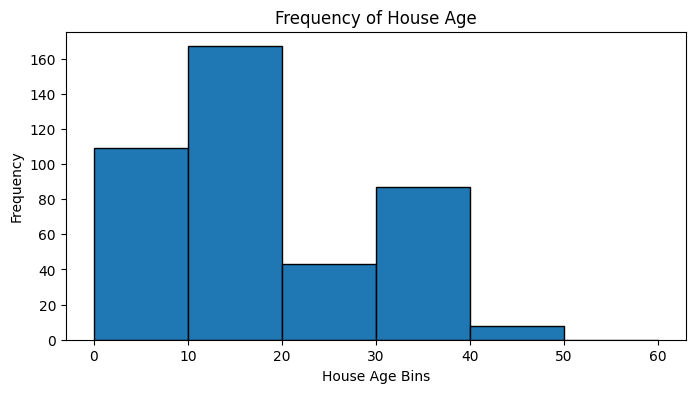

In [ ]:
# Histogram on house age
house_age = pdf_year_month['X2']
house_age
# Create a bar plot
bins = [0, 10, 20, 30, 40, 50, 60]
plt.figure(figsize=(8, 4))
plt.hist(house_age, bins=bins, edgecolor='black')
plt.xlabel('House Age Bins')
plt.ylabel('Frequency')
plt.title('Frequency of House Age')
plt.show()

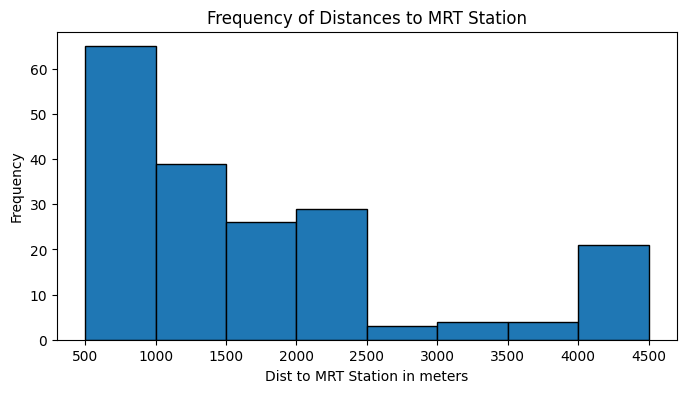

In [ ]:
# Histogram on distance to the nearest MRT station
dist_station = pdf_year_month['X3']
dist_station
# Create a bar plot
bins = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
plt.figure(figsize=(8, 4))
plt.hist(dist_station, bins=bins, edgecolor='black')
plt.xlabel('Dist to MRT Station in meters')
plt.ylabel('Frequency')
plt.title('Frequency of Distances to MRT Station')
plt.show()

#### Visualize the transaction date using the countplot

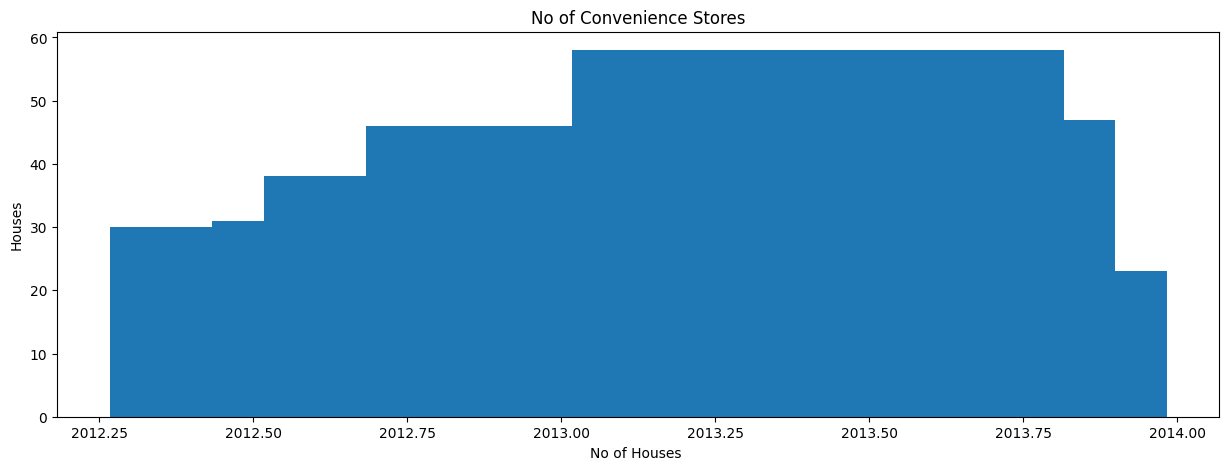

In [ ]:
# Countplot on date from convenience store
dist_store = pdf_year_month['X1'].value_counts()
key = list(dist_store.keys())
frequency = list(dist_store.values)
key, frequency
plt.figure(figsize=(15, 5))
plt.bar(key, frequency)
plt.xlabel('No of Houses ')
plt.ylabel('Houses')
plt.title('No of Convenience Stores')
plt.show()

#### visualize number of convenience stores with appropriate plot.

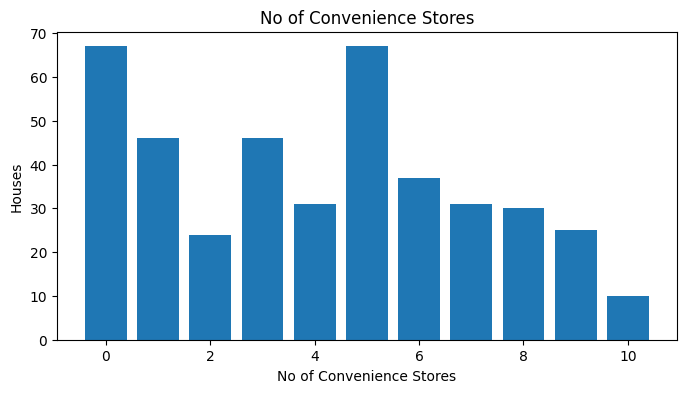

In [ ]:
# Histogram on distance from convenience store
dist_store = pdf_year_month['X4'].value_counts()
key = list(dist_store.keys())
frequency = list(dist_store.values)

plt.figure(figsize=(8, 4))
plt.bar(key, frequency)
plt.xlabel('No of Convenience Stores')
plt.ylabel('Houses')
plt.title('No of Convenience Stores')
plt.show()

#### visualize the geographical distribution of the house prices of unit area

With:

* x-axis = X6 longitude
* y-axis = X5 latitude
* datapoints = Y house price of unit area
* parameters including size `s` and color map `cmap`

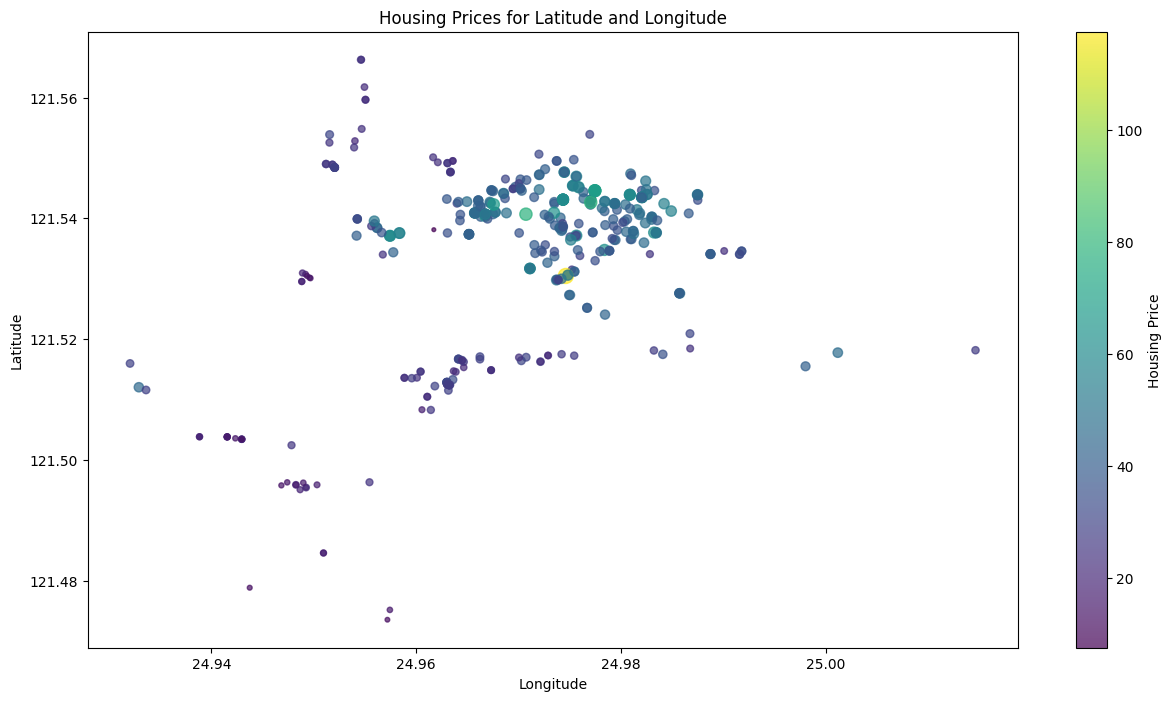

In [ ]:
# Sample data (replace with your actual data)
longitudes = pdf_year_month['X5']
latitudes = pdf_year_month['X6']
housing_prices = pdf_year_month['Y']

# Define size based on housing price (adjust scaling as needed)
sizes = housing_prices

# Define colormap for price variation (choose your preferred colormap)
cmap = plt.cm.viridis
plt.figure(figsize=(15, 8))
# Create the scatter plot
plt.scatter(
    longitudes,
    latitudes,
    s=sizes,
    c=housing_prices,
    cmap=cmap,
    alpha=0.7,  # Adjust transparency if needed
)

# Customize the plot
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Housing Prices for Latitude and Longitude")
plt.colorbar(label="Housing Price")  # Add colorbar for price visualization

# Show the plot
plt.show()

### Feature Scaling

#### Identify the outliers

Use the pairplot or boxplot to identify the outliers

   **Hint:** `sns.pairplot`

In [ ]:
list(pdf_year_month.columns)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y', 'X1Y', 'X1M']

In [ ]:
df_visualization = pdf_year_month[['X1','X2','X3','X4','X5','X6','Y']]

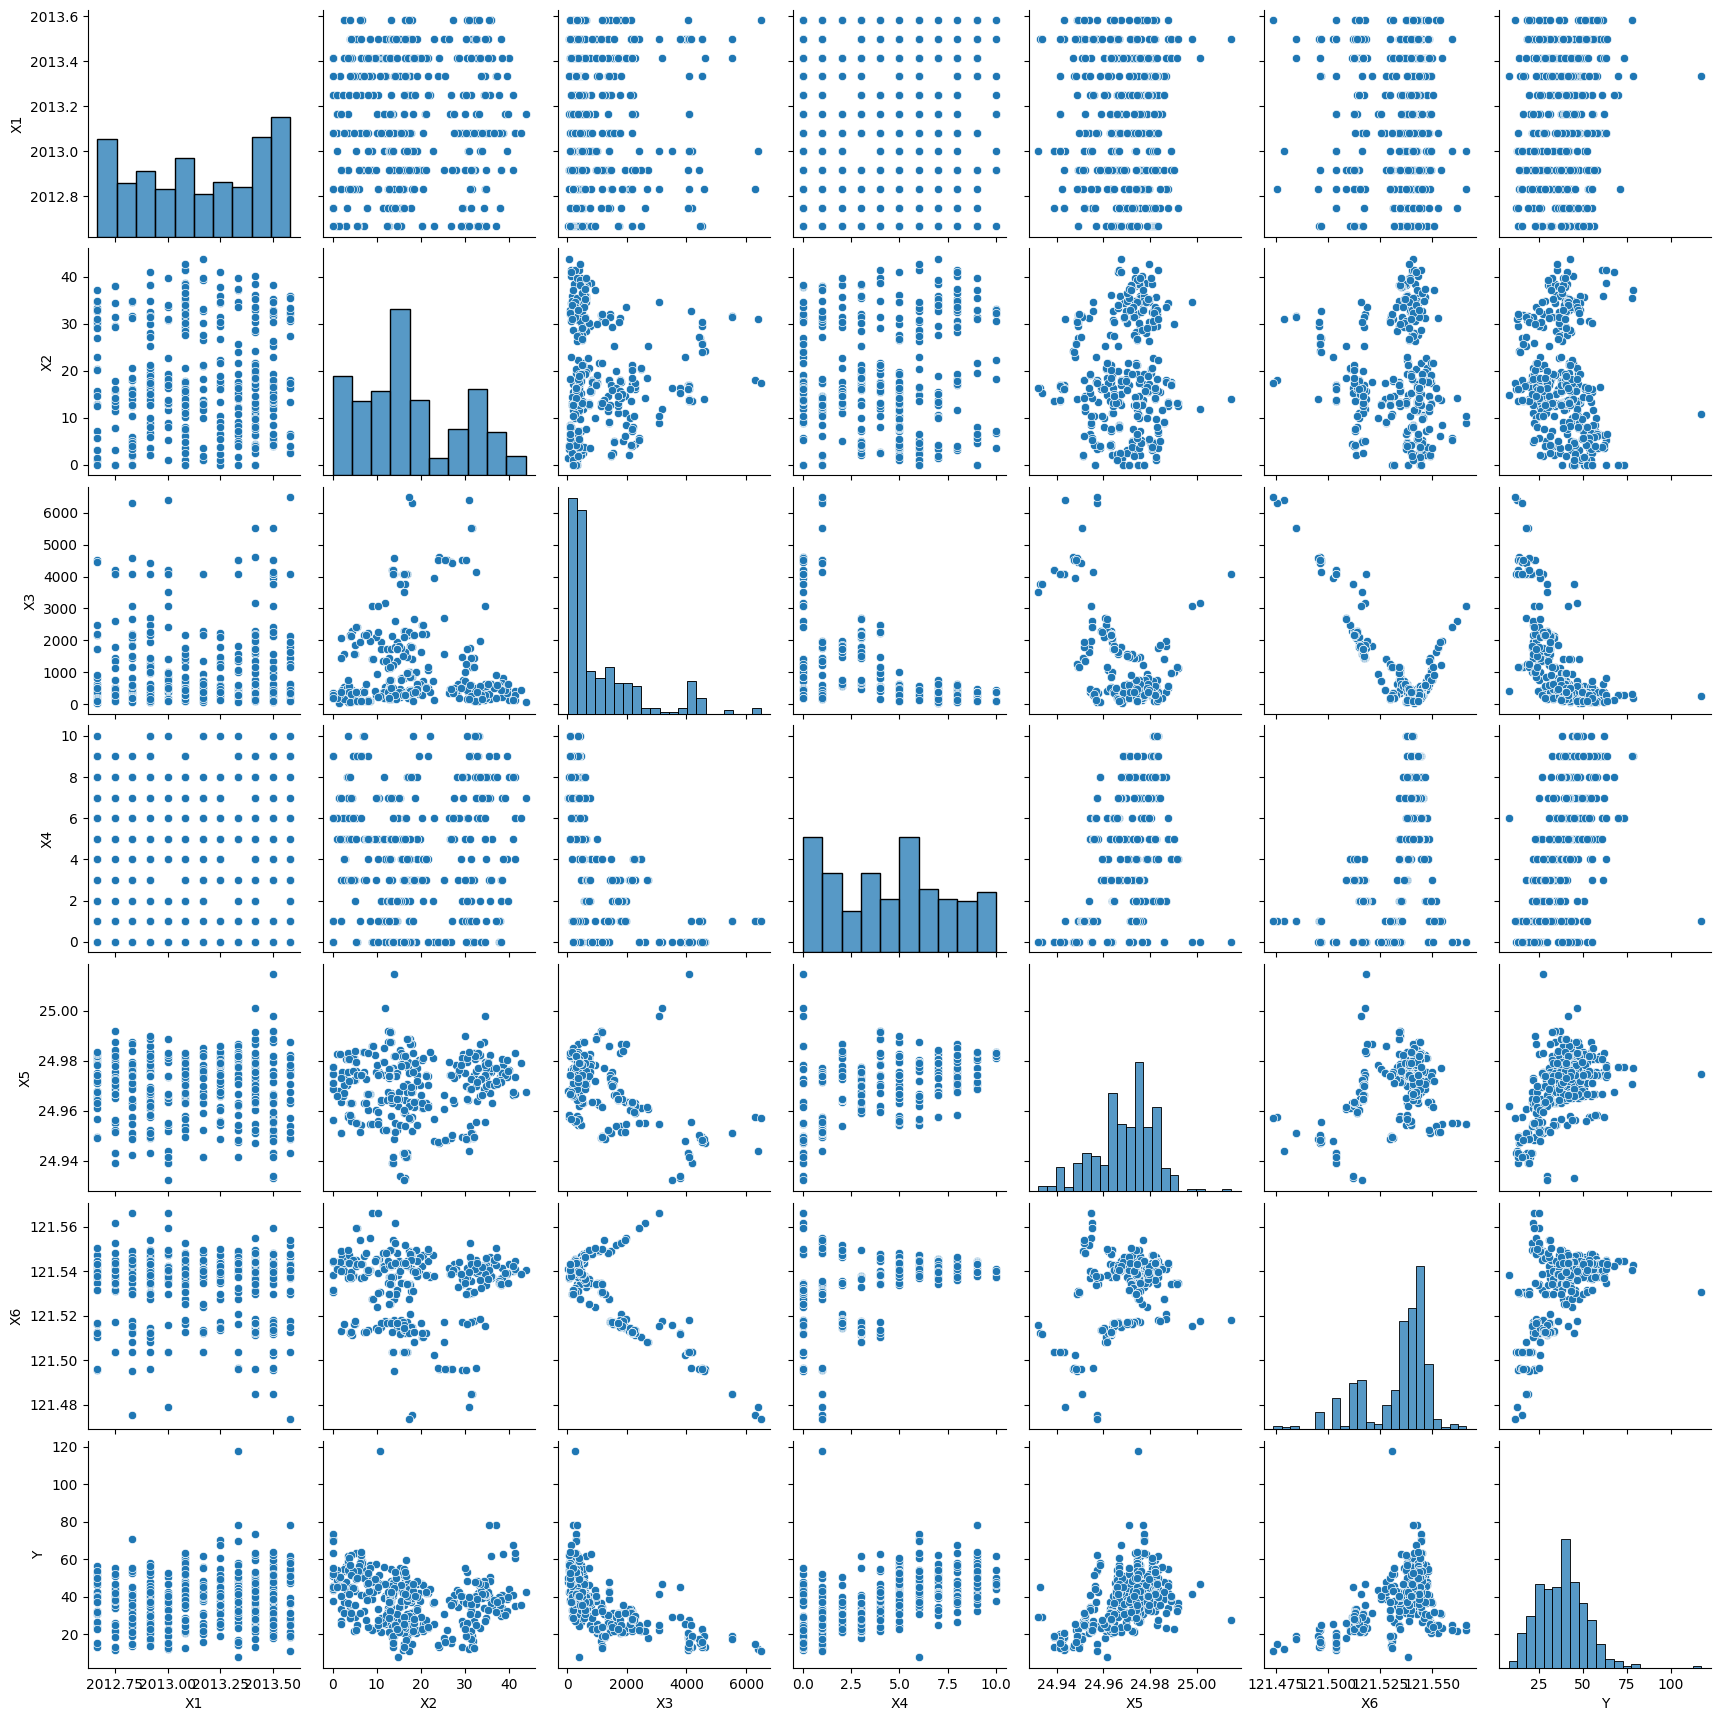

In [ ]:
sns.pairplot(df_visualization)

#### Correlation analysis

create the correlation matrix of all the columns and visualize using the heatmap

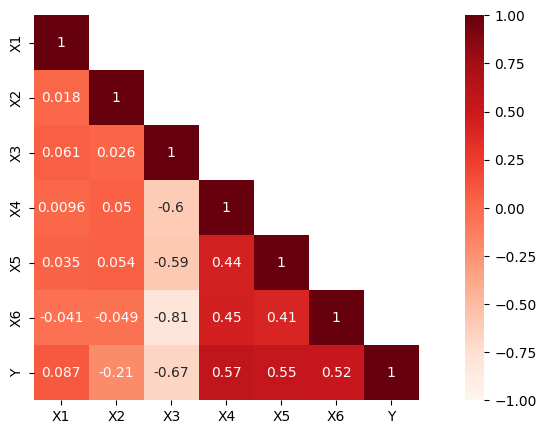

['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']


In [ ]:
matrix = df_visualization.corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False

plt.figure(figsize=(12, 5))
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=-1, square=True,annot=True, cmap="Reds")
plt.show()
print(column_names)

#### Normalization or standardization

select the applicable features using vector assembler and apply scaling using `MinMaxScaler` from pyspark

Hint: [MinMaxScaler](https://spark.apache.org/docs/latest/ml-features#minmaxscaler)

In [ ]:
df_year_month.show()

+--------+----+--------+---+--------+---------+----+----+---+
|      X1|  X2|      X3| X4|      X5|       X6|   Y| X1Y|X1M|
+--------+----+--------+---+--------+---------+----+----+---+
|2012.917|32.0|84.87882| 10|24.98298|121.54024|37.9|2012| 11|
|2012.917|19.5|306.5947|  9|24.98034|121.53951|42.2|2012| 11|
|2013.583|13.3|561.9845|  5|24.98746|121.54391|47.3|2013|  7|
|  2013.5|13.3|561.9845|  5|24.98746|121.54391|54.8|2013|  6|
|2012.833| 5.0|390.5684|  5|24.97937|121.54245|43.1|2012| 10|
|2012.667| 7.1| 2175.03|  3|24.96305|121.51254|32.1|2012|  8|
|2012.667|34.5|623.4731|  7|24.97933|121.53642|40.3|2012|  8|
|2013.417|20.3|287.6025|  6|24.98042|121.54228|46.7|2013|  5|
|  2013.5|31.7|5512.038|  1|24.95095|121.48458|18.8|2013|  6|
|2013.417|17.9| 1783.18|  3|24.96731|121.51486|22.1|2013|  5|
|2013.083|34.8|405.2134|  1|24.97349|121.53372|41.4|2013|  1|
|2013.333| 6.3|90.45606|  9|24.97433| 121.5431|58.1|2013|  4|
|2012.917|13.0|492.2313|  5|24.96515|121.53737|39.3|2012| 11|
|2012.66

In [ ]:
df_year_month.show(5)

+--------+----+--------+---+--------+---------+----+----+---+
|      X1|  X2|      X3| X4|      X5|       X6|   Y| X1Y|X1M|
+--------+----+--------+---+--------+---------+----+----+---+
|2012.917|32.0|84.87882| 10|24.98298|121.54024|37.9|2012| 11|
|2012.917|19.5|306.5947|  9|24.98034|121.53951|42.2|2012| 11|
|2013.583|13.3|561.9845|  5|24.98746|121.54391|47.3|2013|  7|
|  2013.5|13.3|561.9845|  5|24.98746|121.54391|54.8|2013|  6|
|2012.833| 5.0|390.5684|  5|24.97937|121.54245|43.1|2012| 10|
+--------+----+--------+---+--------+---------+----+----+---+
only showing top 5 rows



In [ ]:
assembler = VectorAssembler(
                            inputCols= ['X2', 'X3', 'X5', 'X6', 'X1Y', 'X1M'],
                            outputCol= "features")       # features is the name of output columns which combines all the columns

NameError: name 'VectorAssembler' is not defined

In [ ]:
output = assembler.transform(df_year_month)

In [ ]:
output.select('features').show(10, truncate=False)

+----------------------------------------------+
|features                                      |
+----------------------------------------------+
|[32.0,84.87882,24.98298,121.54024,2012.0,11.0]|
|[19.5,306.5947,24.98034,121.53951,2012.0,11.0]|
|[13.3,561.9845,24.98746,121.54391,2013.0,7.0] |
|[13.3,561.9845,24.98746,121.54391,2013.0,6.0] |
|[5.0,390.5684,24.97937,121.54245,2012.0,10.0] |
|[7.1,2175.03,24.96305,121.51254,2012.0,8.0]   |
|[34.5,623.4731,24.97933,121.53642,2012.0,8.0] |
|[20.3,287.6025,24.98042,121.54228,2013.0,5.0] |
|[31.7,5512.038,24.95095,121.48458,2013.0,6.0] |
|[17.9,1783.18,24.96731,121.51486,2013.0,5.0]  |
+----------------------------------------------+
only showing top 10 rows



In [ ]:
# MinMax Scaling
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(output)

# rescale each feature to range [min, max].
scaledData = scalerModel.transform(output)


In [ ]:
scaledData.show(10)

+--------+----+--------+---+--------+---------+----+----+---+--------------------+--------------------+
|      X1|  X2|      X3| X4|      X5|       X6|   Y| X1Y|X1M|            features|      scaledFeatures|
+--------+----+--------+---+--------+---------+----+----+---+--------------------+--------------------+
|2012.917|32.0|84.87882| 10|24.98298|121.54024|37.9|2012| 11|[32.0,84.87882,24...|[0.73059360730593...|
|2012.917|19.5|306.5947|  9|24.98034|121.53951|42.2|2012| 11|[19.5,306.5947,24...|[0.44520547945205...|
|2013.583|13.3|561.9845|  5|24.98746|121.54391|47.3|2013|  7|[13.3,561.9845,24...|[0.30365296803652...|
|  2013.5|13.3|561.9845|  5|24.98746|121.54391|54.8|2013|  6|[13.3,561.9845,24...|[0.30365296803652...|
|2012.833| 5.0|390.5684|  5|24.97937|121.54245|43.1|2012| 10|[5.0,390.5684,24....|[0.11415525114155...|
|2012.667| 7.1| 2175.03|  3|24.96305|121.51254|32.1|2012|  8|[7.1,2175.03,24.9...|[0.16210045662100...|
|2012.667|34.5|623.4731|  7|24.97933|121.53642|40.3|2012|  8|[34

In [ ]:
scaledData.select("scaledFeatures").show(10,truncate=False)

+------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                        |
+------------------------------------------------------------------------------------------------------+
|[0.7305936073059361,0.00951267162646579,0.616941347552139,0.7193228380417942,0.0,1.0]                 |
|[0.44520547945205485,0.043809390872388755,0.5849491032477332,0.7114513694199474,0.0,1.0]              |
|[0.30365296803652975,0.0833150513098478,0.671231216674745,0.7588958378261307,1.0,0.6363636363636364]  |
|[0.30365296803652975,0.0833150513098478,0.671231216674745,0.7588958378261307,1.0,0.5454545454545454]  |
|[0.11415525114155252,0.05679908927803007,0.573194377120705,0.7431529005822838,0.0,0.9090909090909092] |
|[0.16210045662100458,0.3328333476285392,0.3754241396025207,0.42063834375676107,0.0,0.7272727272727273]|
|[0.7876712328767124,0.09282658134109707,0.572709646146

### Feature Engineering

#### Assemble the features

concatenate all the features into a single vector which can be further passed to the ML algorithm.

**Hint:** `VectorAssembler()`

In [ ]:
scaledData.select("scaledFeatures").show(10,truncate=False)

+------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                        |
+------------------------------------------------------------------------------------------------------+
|[0.7305936073059361,0.00951267162646579,0.616941347552139,0.7193228380417942,0.0,1.0]                 |
|[0.44520547945205485,0.043809390872388755,0.5849491032477332,0.7114513694199474,0.0,1.0]              |
|[0.30365296803652975,0.0833150513098478,0.671231216674745,0.7588958378261307,1.0,0.6363636363636364]  |
|[0.30365296803652975,0.0833150513098478,0.671231216674745,0.7588958378261307,1.0,0.5454545454545454]  |
|[0.11415525114155252,0.05679908927803007,0.573194377120705,0.7431529005822838,0.0,0.9090909090909092] |
|[0.16210045662100458,0.3328333476285392,0.3754241396025207,0.42063834375676107,0.0,0.7272727272727273]|
|[0.7876712328767124,0.09282658134109707,0.572709646146

#### Feature selection and splitting the data

In [ ]:
final_data = scaledData.select("features",'Y')

In [ ]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()

NameError: name 'train_data' is not defined

In [ ]:
test_data.describe().show()

+-------+------------------+
|summary|                 Y|
+-------+------------------+
|  count|               111|
|   mean| 39.67117117117116|
| stddev|14.473269325882285|
|    min|              13.2|
|    max|             117.5|
+-------+------------------+



### Train and Evaluate the model

Using LinearRegression from `pyspark.ml` fit the data and find the coefficients and intercept

In [ ]:
regressor = LinearRegression(featuresCol='features', labelCol='Y')

In [ ]:
#Learn to fit the model from training set
model = regressor.fit(train_data)

Get the predictions and show the table along with actual data and predicted data

In [ ]:
predict = model.transform(test_data)

predict.select(predict.columns[:]).show(10)

+--------------------+----+------------------+
|            features|   Y|        prediction|
+--------------------+----+------------------+
|[0.0,185.4296,24....|37.9| 46.87102837423845|
|[0.0,208.3905,24....|44.0|42.742167688867994|
|[0.0,274.0144,24....|43.5|49.968903285285705|
|[1.1,193.5845,24....|45.1|47.569563223154546|
|[1.1,329.9747,24....|51.8| 48.35126741966087|
|[1.5,23.38284,24....|49.7| 46.10828503819903|
|[1.7,329.9747,24....|50.4|  51.6731038949074|
|[2.5,156.2442,24....|36.9|47.427762715902645|
|[3.1,383.8624,24....|56.2|46.967385405769164|
|[3.2,489.8821,24....|43.2| 43.68125101171427|
+--------------------+----+------------------+
only showing top 10 rows



Calculate the RMSE and $R^2$ of the model

In [ ]:
metrics = model.evaluate(test_data)                             # Using evaluate method we can verify our model's performance

print('Mean absolute error: {}'.format(metrics.meanAbsoluteError))
print('Root mean squared error: {}'.format(metrics.rootMeanSquaredError))
print('R_squared value: {}'.format(metrics.r2))

Mean absolute error: 6.894907979933416
Root mean squared error: 9.965618762173143
R_squared value: 0.4389685517174685
